### Wetland delineation  
This notebook outlines the workflow for wetland delineation using data derived from GEE and applying Random classification model.

#### 1. Initial setup and GEE connection

#### 1.1 Install and import necessary libraries

In [3]:
import ee
import os
import geopandas as gpd
import matplotlib.pyplot as plt
import rasterio     
import numpy as np  

from rasterio.warp import calculate_default_transform, reproject, Resampling

#### 1.2. Connect to GEE

In [4]:
# Authenticate and initialize Earth Engine
ee.Authenticate()
ee.Initialize(project="ee-ogalloethel") 

#### 1.3. Define AOI

In [5]:
# Base directory whee data is stored
base_dir = r"C:\Users\Ethel Ogallo\Documents\ZFL1\Data"

# Verify the directory exists
if not os.path.exists(base_dir):
    print(f"WARNING: Base directory does not exist: {base_dir}\nPlease check your path!")
else:
    print(f"Base directory found: {base_dir}")

# Set AOI from shapefile
shapefile = gpd.read_file(os.path.join(base_dir, 'baringo_bbox/baringo_bbox.shp'))
study_area = ee.Geometry(shapefile.geometry[0].__geo_interface__)

Base directory found: C:\Users\Ethel Ogallo\Documents\ZFL1\Data


#### 2. Downloading data from GEE  
The necessary EO data downloaded include: DEM and slope, Land surface temperature, Derived NDVI and NDWI, Sentinel1-GRD data

#### 2.1 Generic functions to export GEE data

In [ ]:
# Function to read a raster file and return an aligned array
def clip_to_aoi(image):
    """
    Clip an ee.Image to the study_area geometry.
    Args:
        image (ee.Image): The image to clip.
    Returns:   
        ee.Image: The clipped image.
        """
    if not isinstance(image, ee.Image):
        raise TypeError("Input must be an ee.Image")
    return image.clip(study_area)

# Function to export an ee.Image to Google Drive
def export_image_to_drive(image, year, label='image', folder='Exports', scale=30):
    """
    Export an ee.Image to Google Drive.
    Args:
        image (ee.Image): The image to export.
        year (int): The year associated with the image.
        label (str): A label for the exported image.
        folder (str): The folder in Google Drive to save the image.
        scale (int): The scale of the exported image in meters.
    Returns:
        None
    """
    task = ee.batch.Export.image.toDrive(
        image=image,
        description=f'{label}_{year}',
        folder=folder,
        fileNamePrefix=f'{label}_{year}',
        scale=scale,
        region=study_area,
        fileFormat='GeoTIFF',
        maxPixels=1e13
    )
    task.start()
    print(f"Export started: {label}_{year}")


#### 2.1. Download DEM and SLope

In [ ]:
# Function to get DEM and slope
def get_dem():
    """
    Retrieve DEM and slope.

    Returns:
        Tuple[ee.Image, ee.Image]: (DEM image, slope image)
    """
    dem = ee.ImageCollection("COPERNICUS/DEM/GLO30") \
        .filterBounds(study_area).mosaic().select('DEM')
    dem = clip_to_aoi(dem).toFloat().reproject('EPSG:32736', 30)
    slope = ee.Terrain.slope(dem).rename('Slope')
    return dem.rename('DEM'), slope


In [ ]:
# Get DEM and slope
dem, slope = get_dem()

# Export or process each as needed
export_image_to_drive(dem, year='DEM', label='DEM', folder='DEM')
export_image_to_drive(slope, year='Slope', label='Slope', folder='DEM')

In [ ]:
# Function to reproject a raster to match another raster's CRS and dimensions
def reproject_to_match(src_path, ref_path, dst_path):
    """
    Reproject a raster to match the CRS, transform, and shape of a reference raster.
    Args:
        src_path (str): Path to source raster.
        ref_path (str): Path to reference raster.
        dst_path (str): Path to save reprojected raster.
    """
    with rasterio.open(ref_path) as ref, rasterio.open(src_path) as src:
        dst_array = np.empty((ref.height, ref.width), dtype=src.dtypes[0])
        reproject(
            source=src.read(1),
            destination=dst_array,
            src_transform=src.transform,
            src_crs=src.crs,
            dst_transform=ref.transform,
            dst_crs=ref.crs,
            resampling=Resampling.bilinear
        )
        profile = src.profile.copy()
        profile.update({
            'crs': ref.crs,
            'transform': ref.transform,
            'width': ref.width,
            'height': ref.height
        })
        with rasterio.open(dst_path, 'w', **profile) as dst:
            dst.write(dst_array, 1)

# Usage example:
reproject_to_match(
    src_path=os.path.join(base_dir, 'DEM', 'Slope.tif'),
    ref_path=os.path.join(base_dir, 'DEM', 'DEM.tif'),
    dst_path=os.path.join(base_dir, 'DEM', 'Slope_aligned.tif')
)


#### 2.2. Download Landsat Land Surface Temperature (LST) 2015-2025
A cloud mask was appled prior to download

In [ ]:
def cloud_mask(image):
    # Mask clouds and cloud shadows using QA_PIXEL band
    qa = image.select('QA_PIXEL')
    mask = qa.bitwiseAnd(1 << 3).eq(0).And(qa.bitwiseAnd(1 << 5).eq(0))
    return image.updateMask(mask)

def download_lst(year):
    """
    Download Landsat 8 LST for a specific year.
    Args:
        year (int): The year for which to download the LST image.
    Returns:
        ee.Image: The mean LST image for the specified year.
    """
    lst_col = (ee.ImageCollection('LANDSAT/LC08/C02/T1_L2')
               .filterBounds(study_area)
               .filterDate(f'{year}-01-01', f'{year}-12-31')
               .map(cloud_mask)
               .map(lambda img: img.select('ST_B10')
                    .multiply(0.00341802).add(149.0)
                    .subtract(273.15)
                    .rename('LST'))
               .map(clip_to_aoi))
    return lst_col.mean().set({'year': year})


In [ ]:
# Loop through the years and export LST images
years = list(range(2015, 2026))

# Get the LST image for each year and export it to Google Drive
for year in years: 
    lst = download_lst(year)
    export_image_to_drive(lst, year, label='LST_mean', folder='LST')


#### 2.3. Compute NDVI Standard Deviation and Oscillation 2015-2025

In [ ]:
def compute_ndvi(year):
    """
    Compute NDVI for Sentinel-2 images for a specific year.
    Args:
        year (int): The year for which to compute NDVI.
    Returns:   
        ee.Image: The NDVI standard deviation and range for the specified year.
    """
    s2 = (ee.ImageCollection('COPERNICUS/S2_HARMONIZED')
          .filterBounds(study_area)
          .filterDate(f'{year}-01-01', f'{year}-12-31')
          .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 10))
          .map(clip_to_aoi)
          .map(lambda img: img.addBands(
              img.normalizedDifference(['B8', 'B4']).rename('NDVI')))
          .select('NDVI'))

    ndvi_std = s2.reduce(ee.Reducer.stdDev()).rename(f'NDVI_SD_{year}')
    ndvi_range = s2.reduce(ee.Reducer.max()).subtract(
        s2.reduce(ee.Reducer.min())
    ).rename(f'NDVI_Range_{year}')
    return ndvi_std, ndvi_range


In [ ]:
# Export NDVI statistics to Google Drive
for year in years:
    ndvi_std, ndvi_range = compute_ndvi(year)
    export_image_to_drive(ndvi_std, year, label='NDVI_SD', folder='NDVI')
    export_image_to_drive(ndvi_range, year, label='NDVI_Range', folder='NDVI')


#### 2.4. Compute max NDWI from S2 2015-2025

In [ ]:
def compute_ndwi(year):
    """
    Compute maximum NDWI for Sentinel-2 images for a given year.
    Args:
        year (int): Year of interest.
    Returns:
        ee.Image: Max NDWI image.
    """
    s2 = (ee.ImageCollection('COPERNICUS/S2_HARMONIZED')
          .filterBounds(study_area)
          .filterDate(f'{year}-01-01', f'{year}-12-31')
          .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 10))
          .map(clip_to_aoi)
          .map(lambda img: img.normalizedDifference(['B8', 'B3'])
               .rename('NDWI').toFloat()))
    return s2.max().rename(f'NDWI_Max_{year}')


In [ ]:
# Export NDVI statistics 
for year in years:
    ndwi_max = compute_ndwi(year)
    export_image_to_drive(ndwi_max, year, label='NDWI_Max', folder='NDWI')

#### 2.5 Download S1 VV and VH GRD from 2015-2025

In [ ]:
def get_sentinel1_min(year, pol='VV', orbit_pass='ASCENDING'):
    """
    Get annual minimum Sentinel-1 backscatter (dB) for given polarization.

    Args:
        year (int): Year of interest.
        pol (str): Polarization ('VV' or 'VH').
        orbit_pass (str): Orbit pass ('ASCENDING' or 'DESCENDING').
    Returns:
        ee.Image: Minimum Sentinel-1 backscatter image for the specified year and polarization.
    """
    s1 = (ee.ImageCollection('COPERNICUS/S1_GRD')
          .filterDate(f'{year}-01-01', f'{year}-12-31')
          .filterBounds(study_area)
          .filter(ee.Filter.eq('instrumentMode', 'IW'))
          .filter(ee.Filter.eq('orbitProperties_pass', orbit_pass))
          .filter(ee.Filter.eq('resolution_meters', 10))
          .filter(ee.Filter.listContains('transmitterReceiverPolarisation', pol))
          .select(pol))
    return clip_to_aoi(s1.min().rename(f'S1_{pol}_Min_{year}'))


In [ ]:
# Export Sentinel-1 VV and VH minimum backscatter images for each year
for year in years:
    for pol in ['VV', 'VH']:
        img = get_sentinel1_min(year, pol=pol)
        task = ee.batch.Export.image.toDrive(
            image=img,
            description=f'S1_{pol}_Min_{year}',
            folder=f'S1_{pol}',
            fileNamePrefix=f'S1_{pol}_Min_{year}',
            region=study_area,
            scale=10,
            crs='EPSG:4326',
            maxPixels=1e13
        )
        task.start()
        print(f"Started export: S1_{pol}_Min_{year}")


### 4. Feature clasification using Random Forest  

In [6]:
import os
import math
from collections import Counter

import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
from rasterio.io import MemoryFile
from rasterio.transform import rowcol, from_bounds
from rasterio.features import geometry_mask
from rasterio.warp import calculate_default_transform, reproject, Resampling
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.inspection import permutation_importance

from skimage.morphology import opening, square
from scipy.interpolate import griddata


#### 4.1 Training points 

In [7]:
# Define AOI extents
extent = shapefile.total_bounds

# Load training points and reproject to match LST raster CRS if needed
gdf = gpd.read_file(os.path.join(base_dir, 'baringo_training_points.shp'))
with rasterio.open(os.path.join(base_dir, "DEM", "dem.tif")) as src:
    dem_crs = src.crs
if gdf.crs != dem_crs:
    gdf = gdf.to_crs(dem_crs)

gdf.head()


,id,class,geometry
0,1,water,POINT (36.06711 0.56802)
1,2,water,POINT (36.04937 0.67043)
2,3,water,POINT (36.09725 0.47869)
3,4,water,POINT (36.09869 0.47104)
4,5,water,POINT (36.07187 0.34713)


*Visualizing the training data ensuring they are within the bounds*

In [ ]:
# Open rasters
lst = rasterio.open(os.path.join(base_dir, "LST", "LST_mean_2015.tif"))
dem = rasterio.open(os.path.join(base_dir, "DEM", "DEM.tif"))
slope = rasterio.open(os.path.join(base_dir, "DEM", "Slope_aligned.tif"))

rasters = [
    (lst, "Land Surface Temperature (LST)", "inferno"),
    (dem, "Digital Elevation Model (DEM)", "RdYlGn_r"),
    (slope, "Slope", "viridis"),
]

fig, axes = plt.subplots(1, 3, figsize=(22, 10))
classes = gdf['class'].unique()
colors = ['#145a32', '#abb2b9', '#3498db', '#f39c12']

for ax, (raster, title, cmap) in zip(axes, rasters):
    im = ax.imshow(
        raster.read(1),
        cmap=cmap,
        extent=[*extent[[0, 2, 1, 3]]],
        origin='upper'
    )
    for cls, color in zip(classes, colors):
        subset = gdf[gdf['class'] == cls]
        ax.scatter(subset.geometry.x, subset.geometry.y, color=color, s=50, edgecolor='black', label=cls, alpha=0.7)
    fig.colorbar(im, ax=ax, label=title, shrink=0.6)
    ax.set_title(f"{title} with Training Points")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.legend(loc='lower right', fontsize='small', markerscale=0.7, frameon=True, fancybox=True, framealpha=0.8)
    ax.set_aspect('equal')

plt.show()


#### 4.2 Stacking all the raster data  

Ensure all data are of the same shape before attempting to stack  
In this context S1 VV and VH are of different shape thus they are resampled first with DEM as the base raster.

In [9]:
year = 2020

file_map = {
    "LST": os.path.join(base_dir, "LST", f"LST_mean_{year}.tif"),
    "NDWI": os.path.join(base_dir, "NDWI_1", f"NDWI_Max_{year}.tif"),
    "NDVI_SD": os.path.join(base_dir, "NDVI", f"NDVI_SD_{year}.tif"),
    "NDVI_range": os.path.join(base_dir, "NDVI", f"NDVI_Range_{year}.tif"),
    "VV": os.path.join(base_dir, "S1_VV", f"S1_VV_Min_{year}.tif"),
    "VH": os.path.join(base_dir, "S1_VH", f"S1_VH_Min_{year}.tif"),
}

print(f"Raster shapes for year {year}:")
for name, path in file_map.items():
    if os.path.exists(path):
        with rasterio.open(path) as src:
            print(f"{name}: {src.shape}")
    else:
        print(f"{name}: MISSING ({path})")


Raster shapes for year 2020:
LST: (2887, 3209)
NDWI: (2887, 3209)
NDVI_SD: (2887, 3209)
NDVI_range: (2887, 3209)
VV: (8660, 9625)
VH: (8660, 9625)


In [10]:
# resampling the S1 Vv and Vh to match shape with other rasters
vv_vh_by_year = {}

for year in range(2015, 2026):
    vv_vh_by_year[year] = {}

    for name in ["VV", "VH"]:
        path = os.path.join(base_dir, f"S1_{name}", f"S1_{name}_Min_{year}.tif")
        ref_path = os.path.join(base_dir, "LST", f"LST_mean_{year}.tif")

        if not os.path.exists(path):
            continue

        with rasterio.open(ref_path) as ref, rasterio.open(path) as src:
            if (src.shape, src.crs, src.transform) != (ref.shape, ref.crs, ref.transform):
                dst = np.empty(ref.shape, dtype=src.dtypes[0])
                reproject(
                    source=src.read(1),
                    destination=dst,
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=ref.transform,
                    dst_crs=ref.crs,
                    resampling=Resampling.bilinear
                )
                vv_vh_by_year[year][name] = dst
            else:
                vv_vh_by_year[year][name] = src.read(1)

print("Sentinel-1 VV/VH resampling complete.")


Sentinel-1 VV/VH resampling complete.


Stacking all the raster data into a single multi-band raster 


In [11]:
dem = rasterio.open(os.path.join(base_dir, "DEM", "DEM.tif"))

# Stack all raster layers for each year and store in a dictionary
feature_stack_by_year = {}

ref_shape = dem.shape  # Use DEM as the reference shape

for year in range(2015, 2026):
    file_map = {
        "LST": os.path.join(base_dir, "LST", f"LST_mean_{year}.tif"),
        "NDWI": os.path.join(base_dir, "NDWI_1", f"NDWI_Max_{year}.tif"),
        "NDVI_SD": os.path.join(base_dir, "NDVI", f"NDVI_SD_{year}.tif"),
        "NDVI_range": os.path.join(base_dir, "NDVI", f"NDVI_Range_{year}.tif"),
    }

    layers, layer_names = [], []

    # Add disk rasters
    for name, path in file_map.items():
        with rasterio.open(path) as src:
            arr = src.read(1)
            if arr.shape == ref_shape:
                layers.append(arr)
                layer_names.append(name)

    # Add in-memory resampled VV/VH
    for name in ["VV", "VH"]:
        arr = vv_vh_by_year.get(year, {}).get(name)
        if arr is not None and arr.shape == ref_shape:
            layers.append(arr)
            layer_names.append(name)

    # Add DEM and slope
    for raster_obj, name in zip([dem, slope], ["DEM", "Slope"]):
        arr = raster_obj.read(1)
        if arr.shape == ref_shape:
            layers.append(arr)
            layer_names.append(name)

    if len(layers) >= 2:
        feature_stack_by_year[year] = {
            "stack": np.stack(layers, axis=-1),
            "layer_names": layer_names
        }
    else:
        print(f"Year {year}: Not enough valid layers, skipped.")


 Ensuring the multi-band image is within extent of AOI i.e. mask to AOI bounds

In [26]:
from rasterio.features import rasterize

# Create AOI mask
transform, out_shape = dem.transform, dem.shape

# AOI geometries as list
geoms = [feature["geometry"] for feature in shapefile.__geo_interface__["features"]]

aoi_mask = rasterize(
    geoms,
    out_shape=out_shape,
    transform=transform,
    fill=0,  # Fill value for pixels outside the AOI
    all_touched=True,  # includes any pixel touched by polygon boundary
    dtype='uint8'
).astype(bool)



extracting pixel values at the training points 

In [16]:
# Prepare coordinates and transform
coords = [(geom.x, geom.y) for geom in gdf.geometry]
transform = dem.transform

if 'training_data_by_year' not in globals():
    training_data_by_year = {}

for year in feature_stack_by_year:
    feature_stack = feature_stack_by_year[year]['stack']
    rows_cols = [rowcol(transform, x, y) for x, y in coords]
    pixels, labels = [], []
    for (row, col), label in zip(rows_cols, gdf["class"]):
        if 0 <= row < feature_stack.shape[0] and 0 <= col < feature_stack.shape[1]:
            px = feature_stack[row, col, :]
            if not np.any(np.isnan(px)):
                pixels.append(px)
                labels.append(label)

    X = np.array(pixels)
    y = np.array(labels)
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    training_data_by_year[year] = {"X": X, "y": y_encoded, "label_encoder": le}
    
    print(f"Year {year}: {len(y)} samples")


Year 2015: 75 samples
Year 2016: 75 samples
Year 2017: 75 samples
Year 2018: 75 samples
Year 2019: 75 samples
Year 2020: 75 samples
Year 2021: 75 samples
Year 2022: 75 samples
Year 2023: 75 samples
Year 2024: 75 samples
Year 2025: 75 samples


In [40]:
year = 2017
df_samples = pd.DataFrame(training_data_by_year[year]['X'], columns=layer_names)
df_samples['class'] = training_data_by_year[year]['y']
df_samples.iloc[:-10]

,LST,NDWI,NDVI_SD,NDVI_range,VV,VH,DEM,Slope,class
0,27.328320,-0.190625,0.105371,0.378262,-31.505964,-45.250328,973.000000,0.000000,2
1,27.142651,-0.193471,0.124234,0.409944,-26.951418,-43.145054,973.000000,0.000000,2
2,31.207824,0.642843,0.311483,0.867280,-25.523691,-33.189719,978.000000,0.000000,2
3,37.703843,0.621315,0.239628,0.596483,-18.558237,-25.981130,978.375977,0.420843,2
4,45.454811,0.237057,0.019263,0.069949,-23.569426,-34.158134,995.644409,0.356934,2
...,...,...,...,...,...,...,...,...,...
60,31.205465,0.657772,0.048717,0.190597,-16.684925,-21.047054,1006.894592,1.044033,3
61,33.410669,0.542195,0.035095,0.133224,-14.377185,-20.445186,1006.541565,1.413746,3
62,36.562072,0.586736,0.166541,0.505563,-15.182998,-21.583640,1006.990845,0.682176,3
63,42.104302,0.492209,0.138947,0.443400,-18.286780,-28.497826,1004.050232,1.059896,3


#### 4.3 Stratified 5-fold Cross validation with Random Forest  
Training the random forest model using the training dataset 


Combined Train/Test and Cross validation training of the model

Train/Val Samples: 60 | Test Samples: 15
Fold 1 Accuracy: 0.6667
Fold 2 Accuracy: 0.9167
Fold 3 Accuracy: 1.0000
Fold 4 Accuracy: 0.8333
Fold 5 Accuracy: 1.0000

=== Cross-Validation Results ===
CV Accuracy: 0.8833

Classification Report:
              precision    recall  f1-score   support

      forest       0.77      0.77      0.77        13
   rangeland       0.75      0.75      0.75         8
       water       1.00      0.93      0.96        14
     wetland       0.92      0.96      0.94        25

    accuracy                           0.88        60
   macro avg       0.86      0.85      0.86        60
weighted avg       0.88      0.88      0.88        60

Confusion Matrix (Cross-Validation):


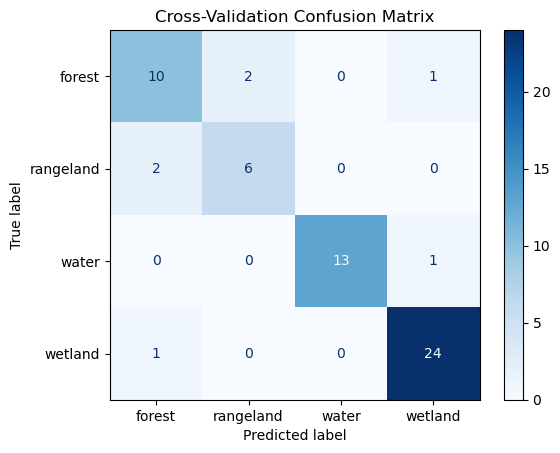


=== Final Test Set Evaluation ===
Test Accuracy: 0.8000

Classification Report:
              precision    recall  f1-score   support

      forest       1.00      0.67      0.80         3
   rangeland       0.67      1.00      0.80         2
       water       0.80      1.00      0.89         4
     wetland       0.80      0.67      0.73         6

    accuracy                           0.80        15
   macro avg       0.82      0.83      0.80        15
weighted avg       0.82      0.80      0.79        15

Confusion Matrix (Test Set):


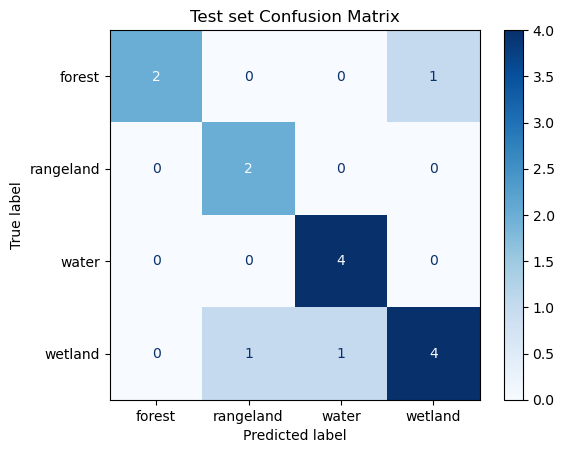

In [63]:
year = 2020
data = training_data_by_year[year]
X, y, le = data["X"], data["y"], data["label_encoder"]

# divide into train/validation and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print(f"Train/Val Samples: {len(X_train_val)} | Test Samples: {len(X_test)}")

# 5-fold cross-validation on training set
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_true, cv_pred = [], []

for i, (train_idx, val_idx) in enumerate(skf.split(X_train_val, y_train_val), 1):
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train_val[train_idx], y_train_val[train_idx])
    y_val_pred = rf.predict(X_train_val[val_idx])
    
    acc = accuracy_score(y_train_val[val_idx], y_val_pred)
    print(f"Fold {i} Accuracy: {acc:.4f}")
    
    cv_true.extend(y_train_val[val_idx])
    cv_pred.extend(y_val_pred)

print(f"\n=== Cross-Validation Results ===")
print(f"CV Accuracy: {accuracy_score(cv_true, cv_pred):.4f}")
print("\nClassification Report:")
print(classification_report(cv_true, cv_pred, target_names=le.classes_))

# Cross-validation confusion matrix
print("Confusion Matrix (Cross-Validation):")
ConfusionMatrixDisplay(
    confusion_matrix(cv_true, cv_pred), display_labels=le.classes_
).plot(cmap="Blues")
plt.title("Cross-Validation Confusion Matrix")
plt.show()

# final model training on combined train/val set
final_rf = RandomForestClassifier(n_estimators=200, random_state=42)
final_rf.fit(X_train_val, y_train_val)
y_test_pred = final_rf.predict(X_test)

print(f"\n=== Final Test Set Evaluation ===")
print(f"Test Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred, target_names=le.classes_))

# final test set confusion matrix
print("Confusion Matrix (Test Set):")
ConfusionMatrixDisplay(
    confusion_matrix(y_test, y_test_pred), display_labels=le.classes_
).plot(cmap="Blues")
plt.title("Test set Confusion Matrix")
plt.show()


#### 4.4 Prediction   
Prediction of the wetland classess based on teh model and estimation of area covered by each class in Ha

In [59]:
# === Predict raster for the same year using trained final_rf ===
print(f"\n=== Predicting for year {year} ===")

# Use the label encoder from training
le = training_data_by_year[year]["label_encoder"]

# Load and stack feature layers
def load_layer(path):
    with rasterio.open(path) as src:
        arr = src.read(1)
        return arr if arr.shape == dem.shape else None

file_map = {
    "LST": f"LST/LST_mean_{year}.tif",
    "NDWI": f"NDWI_1/NDWI_Max_{year}.tif",
    "NDVI_SD": f"NDVI/NDVI_SD_{year}.tif",
    "NDVI_range": f"NDVI/NDVI_Range_{year}.tif",
}

# Load feature layers
layers = [load_layer(os.path.join(base_dir, path)) for path in file_map.values()]
layers += [vv_vh_by_year[year].get(band) for band in ["VV", "VH"]]
layers += [dem.read(1), slope.read(1)]
layers = [layer for layer in layers if layer is not None]

# Stack into 3D array
stack = np.stack(layers, axis=-1)
flat = stack.reshape(-1, stack.shape[-1])
valid_mask = ~np.isnan(flat).any(axis=1)

# Predict using trained final_rf
pred = np.full(flat.shape[0], -1, dtype=int)
pred[valid_mask] = final_rf.predict(flat[valid_mask])
pred_img = pred.reshape(stack.shape[:2])
pred_img[~aoi_mask] = -1  # mask out predictions outside AOI

# === Estimate area per class ===
counts = Counter(pred_img[pred_img >= 0])
lat = (extent[1] + extent[3]) / 2
deg_to_m = 111320
pixel_w = abs(extent[2] - extent[0]) / pred_img.shape[1]
pixel_h = abs(extent[3] - extent[1]) / pred_img.shape[0]
pixel_area_ha = (pixel_w * deg_to_m * math.cos(math.radians(lat))) * (pixel_h * deg_to_m) / 10_000

class_areas = {
    le.inverse_transform([cls])[0]: count * pixel_area_ha
    for cls, count in counts.items()
}

print(f"Estimated area per class (ha) for {year}:")
for cls, area in class_areas.items():
    print(f"  {cls}: {area:,.2f} ha")



=== Predicting for year 2020 ===
Estimated area per class (ha) for 2020:
  forest: 526,494.38 ha
  water: 51,965.95 ha
  wetland: 53,128.02 ha
  rangeland: 151,657.86 ha


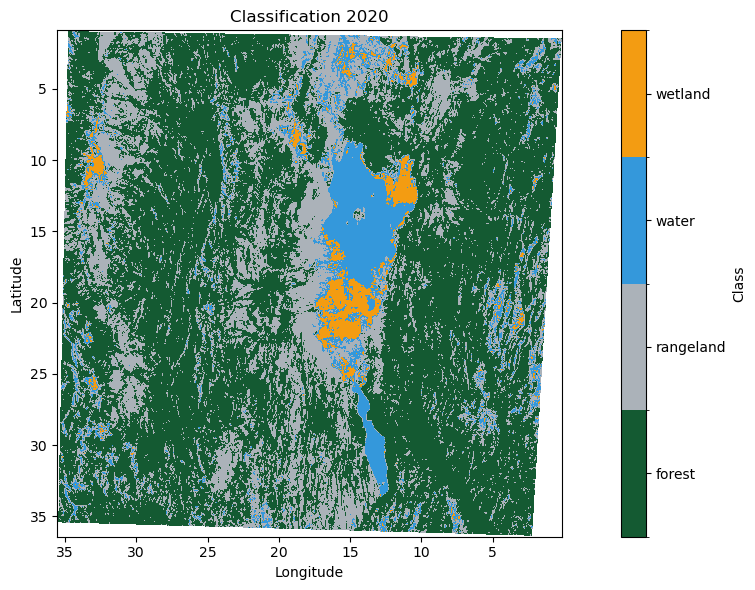

Area per class:
forest: 526,494.38 ha (5,264,943,786 m²)
rangeland: 151,657.86 ha (1,516,578,591 m²)
water: 51,965.95 ha (519,659,499 m²)
wetland: 53,128.02 ha (531,280,188 m²)


In [60]:
# Setup colormap
labels = le.classes_
cmap = ListedColormap(['#145a32', '#abb2b9', '#3498db', '#f39c12'][:len(labels)])
norm = BoundaryNorm(np.arange(len(labels)+1)-0.5, cmap.N)

# Plot
plot_img = np.ma.masked_where(pred_img<0, pred_img)
plt.figure(figsize=(12, 6))
im = plt.imshow(plot_img, cmap=cmap, norm=norm, extent=extent, origin='upper')
plt.xlabel("Longitude"), plt.ylabel("Latitude")
plt.title(f"Classification {year}"), plt.gca().set_aspect('equal')
cbar = plt.colorbar(im, ticks=np.arange(len(labels)))
cbar.ax.set_yticklabels(labels), cbar.set_label("Class")
plt.tight_layout(), plt.show()

#Print area per class
print("Area per class:")
for lbl in labels:
    ha = class_areas.get(lbl, 0)
    print(f"{lbl}: {ha:,.2f} ha ({ha * 10_000:,.0f} m²)")


#### RF for the time series
**_ongoing...._**

In [44]:
def train_model_per_year(year, training_data, test_size=0.2, n_estimators_cv=100, n_estimators_final=200, random_state=42):
    """
    Train Random Forest model for each year with train/test split and cross-validation.
    
    Returns:
        model: final trained model on combined train+val
        metrics: dict with CV and test accuracies and predictions
    """
    data = training_data[year]
    X, y, le = data["X"], data["y"], data["label_encoder"]

    # Split into train+val and test sets
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X, y, test_size=test_size, stratify=y, random_state=random_state
    )

    # Cross-validation training
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    cv_true, cv_pred = [], []
    for train_idx, val_idx in skf.split(X_train_val, y_train_val):
        rf = RandomForestClassifier(n_estimators=n_estimators_cv, random_state=random_state)
        rf.fit(X_train_val[train_idx], y_train_val[train_idx])
        y_val_pred = rf.predict(X_train_val[val_idx])
        cv_true.extend(y_train_val[val_idx])
        cv_pred.extend(y_val_pred)

    cv_accuracy = accuracy_score(cv_true, cv_pred)

    # Final model on combined train+val
    final_rf = RandomForestClassifier(n_estimators=n_estimators_final, random_state=random_state)
    final_rf.fit(X_train_val, y_train_val)

    # Test set evaluation
    y_test_pred = final_rf.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)

    metrics = {
        "cv_true": cv_true,
        "cv_pred": cv_pred,
        "cv_accuracy": cv_accuracy,
        "y_test": y_test,
        "y_test_pred": y_test_pred,
        "test_accuracy": test_accuracy,
        "label_encoder": le,
    }

    return final_rf, metrics


In [45]:
# Train model for a specific year
def prediction_per_year(year, model, feature_stack_by_year, aoi_mask, extent, label_encoder):
    """
    Predict classification raster for one year and compute area per class.
    
    Returns:
        pred_img: 2D numpy array of predictions with -1 outside AOI
        class_areas: dict of class names to area in hectares
    """
    feature_stack = feature_stack_by_year[year]["stack"]
    flat = feature_stack.reshape(-1, feature_stack.shape[-1])
    valid_mask = ~np.isnan(flat).any(axis=1)

    pred = np.full(flat.shape[0], -1, dtype=int)
    pred[valid_mask] = model.predict(flat[valid_mask])
    pred_img = pred.reshape(feature_stack.shape[:2])
    pred_img[~aoi_mask] = -1

    counts = Counter(pred_img[pred_img >= 0])

    # Calculate pixel area in hectares
    lat = (extent[1] + extent[3]) / 2
    deg_to_m = 111320  # meters per degree
    pixel_w = abs(extent[2] - extent[0]) / pred_img.shape[1]
    pixel_h = abs(extent[3] - extent[1]) / pred_img.shape[0]
    pixel_area_ha = (pixel_w * deg_to_m * math.cos(math.radians(lat))) * (pixel_h * deg_to_m) / 10_000

    class_areas = {
        label_encoder.inverse_transform([cls])[0]: count * pixel_area_ha for cls, count in counts.items()
    }

    return pred_img, class_areas

In [46]:
models_by_year = {}
metrics_by_year = {}
predictions_by_year = {}

for year in sorted(training_data_by_year.keys()):
    print(f"\nProcessing year {year}...")

    # Train model
    model, metrics = train_model_per_year(year, training_data_by_year)
    models_by_year[year] = model
    metrics_by_year[year] = metrics

    print(f"Year {year} CV Accuracy: {metrics['cv_accuracy']:.4f}")
    print(f"Year {year} Test Accuracy: {metrics['test_accuracy']:.4f}")

    # Predict
    pred_img, class_areas = prediction_per_year(year, model, feature_stack_by_year, aoi_mask, extent, metrics["label_encoder"])
    predictions_by_year[year] = {
        "pred_img": pred_img,
        "class_areas": class_areas,
    }

    print(f"Prediction complete for year {year}.")                



Processing year 2015...
Year 2015 CV Accuracy: 0.8833
Year 2015 Test Accuracy: 0.8000
Prediction complete for year 2015.

Processing year 2016...
Year 2016 CV Accuracy: 0.8667
Year 2016 Test Accuracy: 0.8667
Prediction complete for year 2016.

Processing year 2017...
Year 2017 CV Accuracy: 0.8667
Year 2017 Test Accuracy: 0.8000
Prediction complete for year 2017.

Processing year 2018...
Year 2018 CV Accuracy: 0.8500
Year 2018 Test Accuracy: 0.8667
Prediction complete for year 2018.

Processing year 2019...
Year 2019 CV Accuracy: 0.8833
Year 2019 Test Accuracy: 0.8000
Prediction complete for year 2019.

Processing year 2020...
Year 2020 CV Accuracy: 0.8833
Year 2020 Test Accuracy: 0.8000
Prediction complete for year 2020.

Processing year 2021...
Year 2021 CV Accuracy: 0.9167
Year 2021 Test Accuracy: 0.7333
Prediction complete for year 2021.

Processing year 2022...
Year 2022 CV Accuracy: 0.9167
Year 2022 Test Accuracy: 0.8667
Prediction complete for year 2022.

Processing year 2023...


Classification Report:
              precision    recall  f1-score   support

      forest       1.00      0.33      0.50         3
   rangeland       0.50      1.00      0.67         2
       water       1.00      1.00      1.00         4
     wetland       0.83      0.83      0.83         6

    accuracy                           0.80        15
   macro avg       0.83      0.79      0.75        15
weighted avg       0.87      0.80      0.79        15

Estimated area per class for year 2015:
  forest: 479503.13 ha
  rangeland: 176396.28 ha
  wetland: 99983.98 ha
  water: 27362.81 ha


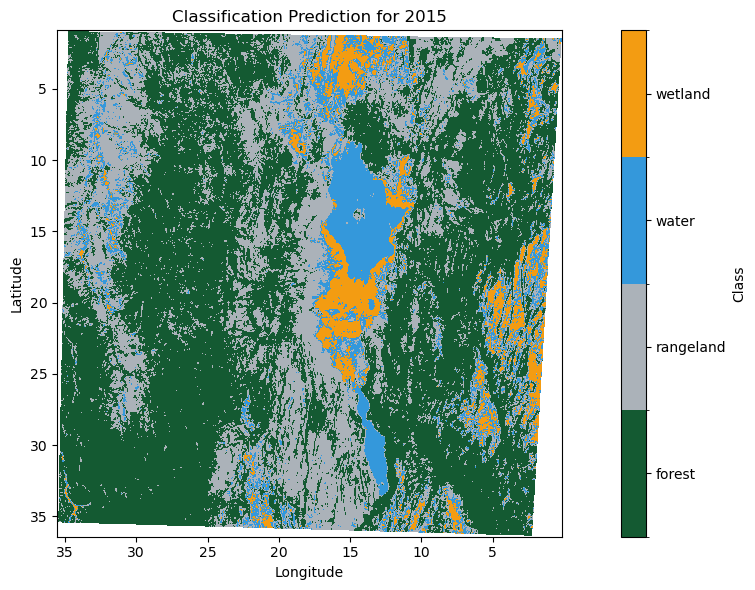

In [64]:
year = 2015
le = metrics_by_year[year]['label_encoder']
labels = le.classes_
pred_img = predictions_by_year[year]['pred_img']
y_test = metrics_by_year[year]['y_test']
y_test_pred = metrics_by_year[year]['y_test_pred']

# Check metrics
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred, target_names=le.classes_))

# Show predicted class areas
print(f"Estimated area per class for year {year}:")
for cls, area in predictions_by_year[year]['class_areas'].items():
    print(f"  {cls}: {area:.2f} ha")

# Plot the prediction map for that year
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
import numpy as np



cmap = ListedColormap(['#145a32', '#abb2b9', '#3498db', '#f39c12'][:len(labels)])
norm = BoundaryNorm(np.arange(len(labels)+1)-0.5, cmap.N)

plot_img = np.ma.masked_where(pred_img < 0, pred_img)

plt.figure(figsize=(12, 6))
im = plt.imshow(plot_img, cmap=cmap, norm=norm, extent=extent, origin='upper')
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title(f"Classification Prediction for {year}")
plt.gca().set_aspect('equal')
cbar = plt.colorbar(im, ticks=np.arange(len(labels)))
cbar.ax.set_yticklabels(labels)
cbar.set_label("Class")
plt.tight_layout()
plt.show()
